# Merge the household survey and cluster locations

In [0]:
import pandas as pd
import numpy as np

file_path = r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\data\RW_2010_DHS_household_data\RWHR61FL\RWHR61FL.DAT'
cluster_path = r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\data\rwanda_clusters_location.csv'
cluster_all = []
wealth_all = []
with open(file_path) as file:
    for l in file:
        cluster = int(l[15:23])
        wealth = int(l[230:238]) / 100000.0
        cluster_all.append(cluster)
        wealth_all.append(wealth)

data = pd.DataFrame({'cluster': cluster_all, 'wlthindf': wealth_all})
cluster_avg_asset = data.groupby('cluster')['wlthindf'].median().reset_index()

data_location = pd.read_csv(cluster_path)[['DHSCLUST', 'LATNUM', 'LONGNUM']]
result = cluster_avg_asset.merge(data_location, how='inner', left_on='cluster', right_on='DHSCLUST')[['cluster', 'wlthindf', 'LATNUM', 'LONGNUM']]
result.rename(columns={'LATNUM': 'latitude', 'LONGNUM':'longitude'}, inplace=True)
result.to_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\rwanda_cluster_avg_asset_2010.csv', index=False)

# Merge Nightlight and DHS data at cluster level

In [0]:
import time
import os
import os.path
from osgeo import gdal, ogr, osr
from scipy import ndimage
from scipy import misc
import cStringIO
gdal.UseExceptions()
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import gridspec
%matplotlib inline
import urllib
import pandas as pd
import numpy as np


def read_raster(raster_path):
    raster_data = gdal.Open(raster_path, gdal.GA_ReadOnly)
    proj = raster_data.GetProjectionRef()
    bands = []
    for index in range(1, raster_data.RasterCount + 1):
        b = raster_data.GetRasterBand(index)
        bands.append(b.ReadAsArray())
        nodata = band.GetNoDataValue()
    bands = np.dstack(bands)
    rows, cols, n_bands = bands.shape

    g = raster_data.GetGeoTransform()
    (topleftx, xs, xrot, toplefty, yrot, ys) = g
    
    xs = 1.0 / int(round(1 / float(xs)))
    ys = - xs
    yind = np.arange(bands.shape[0])
    xind = np.arange(bands.shape[1])
    top_left_x_coords = topleftx + xind * xs
    top_left_y_coords = toplefty + yind * ys
    
    centroid_x_coords = top_left_x_coords + (xs / 2)
    centroid_y_coords = top_left_y_coords + (ys / 2)

    return (xs, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands)


def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lon_idx = np.where(top_left_x_coords < lon)[0][-1]
    lat_idx = np.where(top_left_y_coords > lat)[0][-1]
    return lon_idx, lat_idx

In [0]:
raster_path = 'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\data\F182010.v4\F182010.v4d_web.stable_lights.avg_vis.tif'
x_size, top_left_x_coords, top_left_y_coords, centroid_x_coords, centroid_y_coords, bands_data = read_raster(raster_path)

np.savez(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\nightlight.npz', top_left_x_coords=top_left_x_coords, top_left_y_coords=top_left_y_coords, bands_data=bands_data)

# Get nightlight features for each clusters

In [0]:
def get_nightlight_feature(sample):
    ind, wealth, x, y = sample
    lonind, latind = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    leftind = lonind - 5
    rightind = lonind + 4
    upind = latind - 5
    lowind = latind + 4
    luminosity_all = []
    for i in range(leftind, rightind + 1):
        for j in range(upind, lowind + 1):
            luminosity = bands_data[j, i, 0]
            luminosity_all.append(luminosity)
    luminosity_all = np.asarray(luminosity_all)
    maxi = np.max(luminosity_all)
    mini = np.min(luminosity_all)
    meani = np.mean(luminosity_all)
    mediani = np.median(luminosity_all)
    stdi = np.std(luminosity_all)
    return pd.Series({'id': ind, 'max_': maxi, 'min_': mini, 'mean_': meani, 
                      'median_': mediani, 'std_': stdi, 'wealth': wealth})


clusters = pd.read_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\rwanda_cluster_avg_asset_2010.csv')
data_all = clusters.apply(lambda x: get_nightlight_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)
data_all.to_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\DHS_nightlights.csv', index=None)

(0, 50)

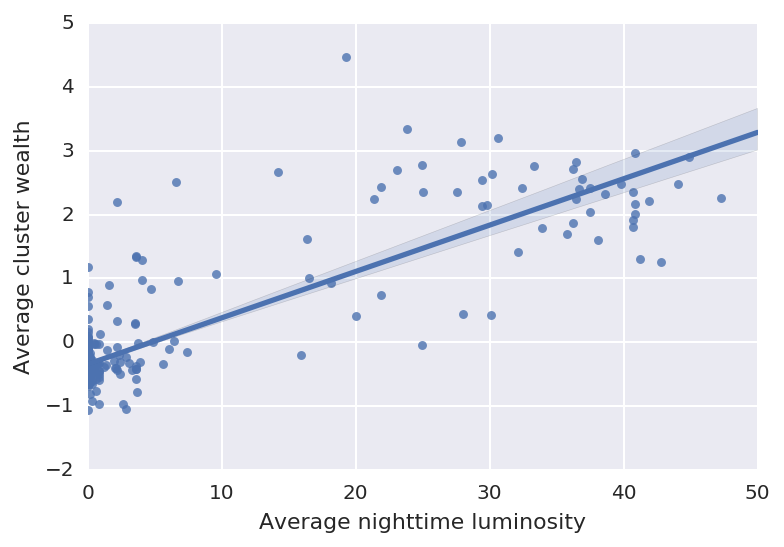

In [0]:
import seaborn as sns
%config InlineBackend.figure_format = 'retina'

ax = sns.regplot(x="mean_", y="wealth", data=data_all)
plt.xlabel('Average nighttime luminosity')
plt.ylabel('Average cluster wealth')
plt.xlim([0, 50])

In [0]:
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge

data_all = pd.read_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\DHS_nightlights.csv')
data_all = data_all[['max_', 'min_', 'mean_', 'median_', 'std_', 'wealth']].as_matrix()
np.random.seed(123)

al = np.logspace(-1, 5, 7)
final = []
for a in al:
    cross = KFold(n_splits=10, shuffle=True)
    scores = []
    for trainind, testind in cross.split(data_all):
        reg = Ridge(alpha=a)
        train = data_all[trainind]
        test = data_all[testind]
        reg.fit(train[:, :-1], train[:, -1])
        s = reg.score(test[:, :-1], test[:, -1])
        scores.append(s)
    final.append(np.mean(scores))

#print( 'R^2 of the best model: {:.3f}'.format(np.max(final)))

Loading Shapefile...


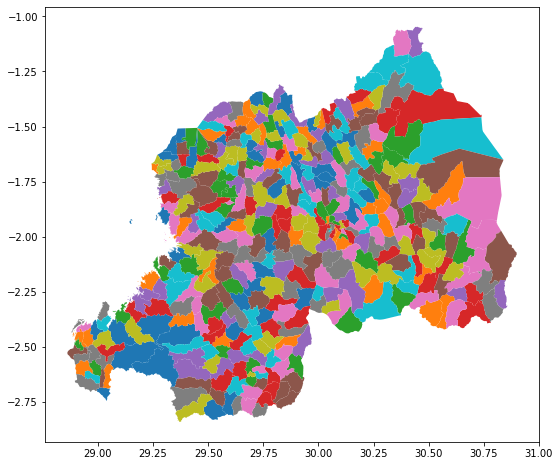

In [0]:
import geopandas as gpd
 
print("Loading Shapefile...")

shapefile = gpd.read_file("C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\data\Sector_Boundary_2012.shp")

shapefile.head()
shapefile.plot(column='Sector', figsize=(16,8))

# Function to read a shape file

In [0]:
def get_shp_extent(shp_file):
    inDriver = ogr.GetDriverByName("ESRI Shapefile")
    inDataSource = inDriver.Open(shp_file, 0)
    inLayer = inDataSource.GetLayer()
    extent = inLayer.
    GetExtent()
    return extent

# Download images from google static API

In [0]:
from retrying import retry

@retry(wait_exponential_multiplier=1000, wait_exponential_max=3600000)
def save_img(url, file_path, file_name):
    a = urllib.urlopen(url).read()
    b = cStringIO.StringIO(a)
    image = ndimage.imread(b, mode='RGB')
    if np.array_equal(image[:,:10,:],image[:,10:20,:]):
        pass
    else:
        misc.imsave(file_path + file_name, image[50:450, :, :])

inShapefile = r"C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\data\Sector_Boundary_2012.shp"
x_min_shp, x_max_shp, y_min_shp, y_max_shp = get_shp_extent(inShapefile)

left_idx, top_idx = get_cell_idx(x_min_shp, y_max_shp, top_left_x_coords, top_left_y_coords)
right_idx, bottom_idx = get_cell_idx(x_max_shp, y_min_shp, top_left_x_coords, top_left_y_coords)

key = 'Enter your api key'
m = 1
for i in range(left_idx, right_idx + 1):
    for j in range(top_idx, bottom_idx + 1):
        lon = centroid_x_coords[i]
        lat = centroid_y_coords[j]
        url = 'https://maps.googleapis.com/maps/api/staticmap?center=' + str(lat) + ',' + \
               str(lon) + '&zoom=16&size=400x500&maptype=satellite&key=' + key
        lightness = bands_data[j, i, 0]
        file_path = 'google_image/' + str(lightness) + '/'
        if not os.path.isdir(file_path):
            os.makedirs(file_path)
        file_name = str(i) + '_' + str(j) +'.jpg'
        save_img(url, file_path, file_name)
        if m % 100 == 0:
            print m
        m += 1

# Use the keras library to use a basic CNN to extract features of the daytime images

In [0]:
from vgg16 import VGG16
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from imagenet_utils import preprocess_input, decode_predictions
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.optimizers import SGD
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from multiprocessing import Pool
import os
import time
import pandas as pd
import numpy as np
from keras.models import Model


imagesall = {} 
for i in range(64):
    di = 'data/google_image/' + str(i) + '/'
    imag = os.listdir(di)
    for f in imag:
        imagesall[f] = i


def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lonind = np.where(top_left_x_coords < lon)[0][-1]
    latind = np.where(top_left_y_coords > lat)[0][-1]
    return lonind, latind


npzfile = np.load(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\nightlight.npz')

top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']

base_model = VGG16(weights='imagenet')
model = Model(input=base_model.input, output=base_model.get_layer('fc2').output)


def get_input_feature(image_file):
    img = image.load_img(image_file, target_size=(224, 224))
    y = image.img_to_array(img)
    y = np.expand_dims(x, axis=0)
    y = preprocess_input(y)
    feat = model.predict(y)
    return feat[0]


def get_daytime_feature(s):
    ind, wealth, x, y = s
    lonind, latind = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    leftind = lonind - 5
    rightind = lonind + 4
    upind = latind - 5
    lowind = latind + 4
    features_all = []
    for i in range(leftind, rightind + 1):
        for j in range(upind, lowind + 1):
            file_name = str(i) + '_' + str(j) + '.jpg'
            if file_name in imagesall:
                luminosity = imagesall[file_name]
                feat = get_input_feature('data/google_image/' + str(luminosity) + '/' + file_name)
                features_all.append(feat)
    if len(features_all) == 0:
        #print( 'nononono: ' + str(ind))
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_all = np.asarray(features_all)
        return np.append(np.mean(features_all, axis=0), wealth).tolist()


clusters = pd.read_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\bdd-master\bdd-master\PS1\intermediate_files\rwanda_cluster_avg_asset_2010.csv'
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\bdd-master\bdd-master\PS1\intermediate_files\google_image_features_cnn.csv', data_all)

In [0]:
from sklearn.decomposition import PCA

al = np.logspace(-1, 5, 7)
final = []
for a in al:
    cross = KFold(n_splits=10, shuffle=True)
    scores = []
    for trainind, testind in cross.split(data_all):
        reg = Ridge(alpha=a)
        train = data_all[trainind]
        test = data_all[testind]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print( 'R^2 of the best model: {:.3f}'.format(np.max(final)))

R^2 of the best model: 0.694


# Divide images into three groups

In [0]:
def move_to_group(small, big, ind):
    n = 'data/google_image_cnn/class_' + str(ind) + '/'
    if not os.path.isdir(n):
        os.makedirs(n)
    for i in range(small, big):
        path = 'data/google_image/' + str(i) + '/'
        for j in os.listdir(path):
            copyfile(path + j, n + j)

move_to_group(0, 3, 1)
move_to_group(3, 35, 2)
move_to_group(35, 64, 3)

# Use nightlight to retrain CNN and extract features

In [0]:
from vgg16 import VGG16
import numpy as np
from keras.preprocessing import image
from keras.models import Sequential
from imagenet_utils import preprocess_input, decode_predictions
from keras.layers.convolutional import Convolution2D, AveragePooling2D
from keras.optimizers import SGD
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dense
from keras.layers import Dropout
from keras.models import Model
from multiprocessing import Pool
import os
import time

model_old = VGG16(weights='imagenet', include_top=False)

def get_input_feature(img_path):
    img = image.load_img(img_path)
    x = image.img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    features = model_old.predict(x)
    return features[0]

all_figures = []
trainLabels = []

p1 = 'google_image_cnn_upsampling/train/class_1/'
c1 = os.listdir(p1)
trainLabels += [[1, 0, 0]] * len(c1)
all_figures += [p1 + i for i in c1]

p2 = 'google_image_cnn_upsampling/train/class_2/'
c2 = os.listdir(p2)
trainLabels += [[0, 1, 0]] * len(c2)
all_figures += [p2 + i for i in c2]

p3 = 'google_image_cnn_upsampling/train/class_3/'
c3 = os.listdir(p3)
trainLabels += [[0, 0, 1]] * len(c3)
all_figures += [p3 + i for i in c3]


trainData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    trainData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        t1 = time.time()


x_all = np.asarray(trainData)
y_all = np.asarray(trainLabels)

all_figures = []
testLabels = []

p1 = 'google_image_cnn_upsampling/test/class_1/'
c1 = os.listdir(p1)
testLabels += [[1, 0, 0]] * len(c1)
all_figures += [p1 + i for i in c1]

p2 = 'google_image_cnn_upsampling/test/class_2/'
c2 = os.listdir(p2)
testLabels += [[0, 1, 0]] * len(c2)
all_figures += [p2 + i for i in c2]

p3 = 'google_image_cnn_upsampling/test/class_3/'
c3 = os.listdir(p3)
testLabels += [[0, 0, 1]] * len(c3)
all_figures += [p3 + i for i in c3]

testData = []
t1 = time.time()
for idx, i in enumerate(all_figures):
    a = get_input_feature(i)
    testData.append(a)
    if idx % 1000 == 0:
        t2 = time.time()
        t1 = time.time()

x_all_test = np.asarray(testData)
y_all_test = np.asarray(testLabels)

np.savez('google_image_feature_upsampling.npz', x_all=x_all, y_all=y_all, 
         x_all_test=x_all_test, y_all_test=y_all_test)

x_train = x_all
x_test = x_all_test
y_train = y_all
y_test = y_all_test

model = Sequential()
model.add(Convolution2D(4096, 6, 6, activation='relu', input_shape=(12, 12, 512), subsample=(6, 6), name='input'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, activation='relu', subsample=(1, 1), name='conv_7'))
model.add(Dropout(0.5))
model.add(Convolution2D(4096, 1, 1, subsample=(1, 1), name='conv_8'))
model.add(AveragePooling2D((2, 2), strides=(1, 1), name='add_pool'))

model.add(Flatten(name='flatten'))
model.add(Dense(3))
model.add(Activation("softmax"))

opt = SGD(lr=1e-2)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

model.fit(x_train, y_train, batch_size=100, nb_epoch=10, verbose=1)

score = model.evaluate(x_test, y_test, verbose=0)  

In [0]:
npzfile = np.load('intermediate_files/nightlight.npz')

top_left_x_coords = npzfile['top_left_x_coords']
top_left_y_coords = npzfile['top_left_y_coords']
bands_data = npzfile['bands_data']


def get_cell_idx(lon, lat, top_left_x_coords, top_left_y_coords):
    lonind = np.where(top_left_x_coords < lon)[0][-1]
    latind = np.where(top_left_y_coords > lat)[0][-1]
    return lonind, latind


model_select = Model(input=model.input, output=model.get_layer('add_pool').output)


imagesall = {} 
for i in range(64):
    di = 'data/google_image/' + str(i) + '/'
    imag = os.listdir(di)
    for j in imag:
        imagesall[j] = i


def get_input_feature_2(img_path):
    img = image.load_img(img_path)
    y = image.img_to_array(img)
    y = np.expand_dims(y, axis=0)
    y = preprocess_input(y)
    feat = model_old.predict(y)
    poolfeat = model_select.predict(feat)
    return poolfeat[0]


def get_daytime_feature(s):
    ind, wealth, x, y = s
    lonind, latind = get_cell_idx(x, y, top_left_x_coords, top_left_y_coords)
    leftind = lonind - 5
    rightind = lonind + 4
    upind = latind - 5
    lowind = latind + 4
    features_all = []
    for i in range(leftind, rightind + 1):
        for j in range(upind, lowind + 1):
            f = str(i) + '_' + str(j) + '.jpg'
            if f in imagesall:
                luminosity = imagesall[f]
                feat = get_input_feature_2('data/google_image/' + str(luminosity) + '/' + f)
                features_all.append(feat)
    if len(features_all) == 0:
        #print( 'nononono: ' + str(ind))
        return np.asarray([np.nan] * 4096 + [wealth]).tolist()
    else:
        features_all = np.asarray(features_all)
        return np.append(np.mean(features_all, axis=0), wealth).tolist()


clusters = pd.read_csv(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\rwanda_cluster_avg_asset_2010.csv')
clusters['feature'] = clusters.apply(lambda x: get_daytime_feature([x['cluster'], x['wlthindf'], 
                                                                    x['longitude'], x['latitude']]), axis=1)

data_all = clusters['feature']
data_all = np.asarray([i for i in data_all])
data_all = data_all[~np.isnan(data_all).any(axis=1)]

np.savetxt(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\google_image_features_cnn_retrain.csv', data_all)

In [0]:
data_all = np.loadtxt(r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_filesgoogle_image_features_cnn_retrain.csv')

al = np.logspace(-1, 5, 7)

final = []
for a in al:
    cross = KFold(n_splits=10, shuffle=True)
    scores = []
    for trainind, testind in cross.split(data_all):
        reg = Ridge(alpha=a)
        train = data_all[trainind]
        test = data_all[testind]
        train_x = train[:, :-1]
        train_y = train[:, -1]
        test_x = test[:, :-1]
        test_y = test[:, -1]
        pca = PCA(n_components=100)
        pca.fit(train_x)
        train_x = pca.transform(train_x)
        test_x = pca.transform(test_x)
        reg.fit(train_x, train_y)
        s = reg.score(test_x, test_y)
        scores.append(s)
    final.append(np.mean(scores))

print( 'R^2 of the best model: {:.3f}'.format(np.max(final)))


R^2 of the best model: 0.725


In [0]:
import pandas as pd
import matplotlib.pyplot as plt

path_to_csv = r'C:\Users\dhaval\Desktop\SEM 6\ML\Project\mytry\intermediate_files\google_image_features_cnn_retrain.csv'
df = pd.read_excel(path_to_csv, index_col = 0)

plt.imshow(df, cmap = 'hot', interpolation = 'nearest')

plt.show()

<img src="D:\DA\Sem6\PpNew\pp\figure\pmap.png" alt="Map"/>